In [23]:
import pandas as pd
import yfinance as yf
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [24]:
# Pull Data 
doge_data = yf.download('doge-USD', start='2017-01-01', end='2022-01-01')
doge_df = pd.DataFrame(doge_data)

[*********************100%***********************]  1 of 1 completed


In [25]:
doge_df

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2017-11-09,0.001207,0.001415,0.001181,0.001415,0.001415,6259550
2017-11-10,0.001421,0.001431,0.001125,0.001163,0.001163,4246520
2017-11-11,0.001146,0.001257,0.001141,0.001201,0.001201,2231080
2017-11-12,0.001189,0.001210,0.001002,0.001038,0.001038,3288960
2017-11-13,0.001046,0.001212,0.001019,0.001211,0.001211,2481270
...,...,...,...,...,...,...
2021-12-28,0.187847,0.187885,0.172738,0.174117,0.174117,954075337
2021-12-29,0.174095,0.177339,0.166760,0.167765,0.167765,823628336
2021-12-30,0.168137,0.175771,0.165381,0.171313,0.171313,599236772


In [26]:
doge_df = doge_df.drop(columns=['Adj Close', 'Volume', 'Open', 'High', 'Low'])
doge_df.head()

,Close
Date,
2017-11-09,0.001415
2017-11-10,0.001163
2017-11-11,0.001201
2017-11-12,0.001038
2017-11-13,0.001211


In [27]:
short_window = 8
long_window = 21

In [28]:
# Generate the short and long moving averages (50 and 100 days, respectively)
doge_df['SMA8'] = doge_df['Close'].rolling(window=short_window).mean()
doge_df['SMA21'] = doge_df['Close'].rolling(window=long_window).mean()

# Prepopulate the `Signal` for trading
doge_df['Signal'] = 0.0

In [29]:
doge_df.dropna()

,Close,SMA8,SMA21,Signal
Date,,,,
2017-11-29,0.002080,0.002019,0.001568,0.0
2017-11-30,0.002079,0.002051,0.001600,0.0
2017-12-01,0.002148,0.002083,0.001647,0.0
2017-12-02,0.002149,0.002113,0.001692,0.0
2017-12-03,0.002223,0.002132,0.001749,0.0
...,...,...,...,...
2021-12-28,0.174117,0.182250,0.175263,0.0
2021-12-29,0.167765,0.181824,0.174721,0.0
2021-12-30,0.171313,0.181586,0.174808,0.0


In [30]:
# Generate the trading signal 0 or 1,
# where 1 is when short-window (SMA50) is greater than the long (SMA 100)
# and 0 otherwise
doge_df['Signal'][short_window:] = np.where(
    doge_df['SMA8'][short_window:] > doge_df['SMA21'][short_window:], 1.0, 0.0
)

In [31]:
# Calculate the points in time when the Signal value changes
# Identify trade entry (1) and exit (-1) points
doge_df['Entry/Exit'] = doge_df['Signal'].diff()

# Review the DataFrame
doge_df.tail(10)

,Close,SMA8,SMA21,Signal,Entry/Exit
Date,,,,,
2021-12-23,0.184490,0.172580,0.174129,0.0,0.0
2021-12-24,0.186622,0.174226,0.173493,1.0,1.0
2021-12-25,0.190657,0.176932,0.174055,1.0,0.0
2021-12-26,0.190020,0.179134,0.174948,1.0,0.0
2021-12-27,0.187705,0.181401,0.175391,1.0,0.0
2021-12-28,0.174117,0.182250,0.175263,1.0,0.0
2021-12-29,0.167765,0.181824,0.174721,1.0,0.0
2021-12-30,0.171313,0.181586,0.174808,1.0,0.0
2021-12-31,0.170496,0.179837,0.175098,1.0,0.0


In [32]:
# Filling missing values with the previous ones
doge_df = doge_df.fillna(method ='pad')

In [33]:
doge_rnn = doge_df[['Close']]
doge_rnn

,Close
Date,
2017-11-09,0.001415
2017-11-10,0.001163
2017-11-11,0.001201
2017-11-12,0.001038
2017-11-13,0.001211
...,...
2021-12-28,0.174117
2021-12-29,0.167765
2021-12-30,0.171313


In [34]:
 def window_data(df, window, feature_col_number, target_col_number):
    """
    This function accepts the column number for the features (X) and the target (y).
    It chunks the data up with a rolling window of Xt - window to predict Xt.
    It returns two numpy arrays of X and y.
    """
    X = []
    y = []
    for i in range(len(df) - window):
        features = df.iloc[i : (i + window), feature_col_number]
        target = df.iloc[(i + window), target_col_number]
        X.append(features)
        y.append(target)
    return np.array(X), np.array(y).reshape(-1, 1)

In [35]:
doge_rnn.isnull().sum()

Close    0
dtype: int64

In [36]:
# Define the window size
window_size = 30

# Set the index of the feature and target columns
feature_column = 0
target_column = 0

# Create the features (X) and target (y) data using the window_data() function.
X, y = window_data(doge_rnn, window_size, feature_column, target_column)

# Print a few sample values from X and y
print (f"X sample values:\n{X[:3]} \n")
print (f"y sample values:\n{y[:3]}")

X sample values:
[[0.001415 0.001163 0.001201 0.001038 0.001211 0.001184 0.001339 0.00139
  0.001313 0.001373 0.001376 0.001394 0.001389 0.001823 0.001891 0.001908
  0.002072 0.002026 0.001988 0.002363 0.00208  0.002079 0.002148 0.002149
  0.002223 0.002463 0.002479 0.002663 0.00272  0.002779]
 [0.001163 0.001201 0.001038 0.001211 0.001184 0.001339 0.00139  0.001313
  0.001373 0.001376 0.001394 0.001389 0.001823 0.001891 0.001908 0.002072
  0.002026 0.001988 0.002363 0.00208  0.002079 0.002148 0.002149 0.002223
  0.002463 0.002479 0.002663 0.00272  0.002779 0.002617]
 [0.001201 0.001038 0.001211 0.001184 0.001339 0.00139  0.001313 0.001373
  0.001376 0.001394 0.001389 0.001823 0.001891 0.001908 0.002072 0.002026
  0.001988 0.002363 0.00208  0.002079 0.002148 0.002149 0.002223 0.002463
  0.002479 0.002663 0.00272  0.002779 0.002617 0.002547]] 

y sample values:
[[0.002617]
 [0.002547]
 [0.002798]]


In [37]:
 # Manually splitting the data
split = int(0.7 * len(X))

X_train = X[: split]
X_test = X[split:]

y_train = y[: split]
y_test = y[split:]

In [38]:
# Importing the MinMaxScaler from sklearn
from sklearn.preprocessing import MinMaxScaler

# Create a MinMaxScaler object
scaler = MinMaxScaler()

# Fit the MinMaxScaler object with the features data X
scaler.fit(X_train)

# Scale the features training and testing sets
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

# Fit the MinMaxScaler object with the target data Y
scaler.fit(y_train)

# Scale the target training and testing sets
y_train = scaler.transform(y_train)
y_test = scaler.transform(y_test)

In [39]:
# Reshape the features data
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

# Print some sample data after reshaping the datasets
print (f"X_train sample values:\n{X_train[:3]} \n")
print (f"X_test sample values:\n{X_test[:3]}")

X_train sample values:
[[[0.02348909]
  [0.00778816]
  [0.01015576]
  [0.        ]
  [0.00169768]
  [0.        ]
  [0.00164818]
  [0.00488114]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.00031849]
  [0.        ]
  [0.01839111]
  [0.02276381]
  [0.02385699]
  [0.03440293]
  [0.03144493]
  [0.02900135]
  [0.05311556]
  [0.03491737]
  [0.03485307]
  [0.03929009]
  [0.03935439]
  [0.04411292]
  [0.05954601]
  [0.06057489]
  [0.07240693]
  [0.07607228]
  [0.07986625]]

 [[0.00778816]
  [0.01015576]
  [0.        ]
  [0.01077882]
  [0.        ]
  [0.00974597]
  [0.00488114]
  [0.        ]
  [0.00380349]
  [0.0001909 ]
  [0.00114562]
  [0.        ]
  [0.02764508]
  [0.02276381]
  [0.02385699]
  [0.03440293]
  [0.03144493]
  [0.02900135]
  [0.05311556]
  [0.03491737]
  [0.03485307]
  [0.03929009]
  [0.03935439]
  [0.04411292]
  [0.05954601]
  [0.06057489]
  [0.07240693]
  [0.07607228]
  [0.07986625]
  [0.06944891]]

 [[0.01015576]
  [0.        ]
  [0.01077882]
  [0.00909658]
  [0.00974597

In [40]:
 # Importing required Keras modules
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

In [41]:
# Define the LSTM RNN model.
model = Sequential()

# Initial model setup

number_units = 30
dropout_fraction = 0.2

# Layer 1
model.add(LSTM(
    units=number_units,
    return_sequences=True,
    input_shape=(X_train.shape[1], 1))
    )
model.add(Dropout(dropout_fraction))

# Layer 2
model.add(LSTM(units=number_units, return_sequences=True))
model.add(Dropout(dropout_fraction))

# Layer 3
model.add(LSTM(units=number_units))
model.add(Dropout(dropout_fraction))

# Output layer
model.add(Dense(1))

In [42]:
# Compile the model
model.compile(optimizer="adam", loss="mean_squared_error")

In [43]:
# Show the model summary
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 30, 30)            3840      
                                                                 
 dropout (Dropout)           (None, 30, 30)            0         
                                                                 
 lstm_1 (LSTM)               (None, 30, 30)            7320      
                                                                 
 dropout_1 (Dropout)         (None, 30, 30)            0         
                                                                 
 lstm_2 (LSTM)               (None, 30)                7320      
                                                                 
 dropout_2 (Dropout)         (None, 30)                0         
                                                                 
 dense (Dense)               (None, 1)                 3

In [44]:
 # Train the model
model.fit(X_train, y_train, epochs=10, shuffle=False, batch_size=90, verbose=1)

Epoch 1/10
12/12 [==============================] - 9s 66ms/step - loss: 0.0206
Epoch 2/10
12/12 [==============================] - 1s 59ms/step - loss: 0.0082
Epoch 3/10
12/12 [==============================] - 1s 60ms/step - loss: 0.0060
Epoch 4/10
12/12 [==============================] - 1s 58ms/step - loss: 0.0053
Epoch 5/10
12/12 [==============================] - 1s 57ms/step - loss: 0.0048
Epoch 6/10
12/12 [==============================] - 1s 57ms/step - loss: 0.0042
Epoch 7/10
12/12 [==============================] - 1s 57ms/step - loss: 0.0045
Epoch 8/10
12/12 [==============================] - 1s 60ms/step - loss: 0.0040
Epoch 9/10
12/12 [==============================] - 1s 67ms/step - loss: 0.0037
Epoch 10/10
12/12 [==============================] - 1s 59ms/step - loss: 0.0032


In [45]:
# Evaluate the model
model.evaluate(X_test, y_test, verbose=0)

161.63821411132812

In [46]:
# Make predictions using the testing data X_test
predicted = model.predict(X_test)

In [47]:
# Recover the original prices instead of the scaled version
predicted_prices = scaler.inverse_transform(predicted)
real_prices = scaler.inverse_transform(y_test.reshape(-1, 1))

In [49]:
# Create a DataFrame of Real and Predicted values
stocks = pd.DataFrame({
    "Actual": real_prices.ravel(),
    "Predicted": predicted_prices.ravel()
}, index = doge_rnn.index[-len(real_prices): ]) 

# Show the DataFrame's head
stocks.head()

,Actual,Predicted
Date,,
2020-10-13,0.002635,0.002537
2020-10-14,0.002637,0.002539
2020-10-15,0.002593,0.002542
2020-10-16,0.002612,0.002544
2020-10-17,0.002581,0.002546


<AxesSubplot:title={'center':'Actual Vs. Predicted ADA prices'}, xlabel='Date'>

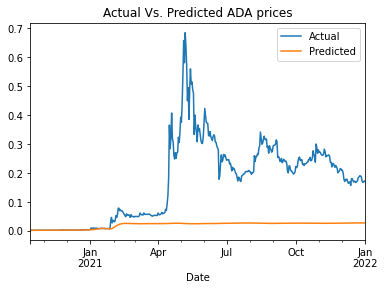

In [50]:
 # Plot the real vs predicted prices as a line chart
stocks.plot(title="Actual Vs. Predicted ADA prices")